# Baseline models

## 0. Import library

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


import warnings;
warnings.filterwarnings('ignore')

In [2]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 1. Import data and sampling

In [3]:
df = pd.read_csv('reviews_cleaned.csv', parse_dates=['timestamp_created'])

In [4]:
df.head()

,recommendationid,review,timestamp_created,voted_up
0,132354840,loe love love game purchased sale would recomm...,2023-02-07,True
1,132354176,fun,2023-02-07,True
2,132353890,full gen z game,2023-02-07,False
3,132353500,good,2023-02-07,True
4,132352818,captivating like movie,2023-02-07,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462578 entries, 0 to 462577
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   recommendationid   462578 non-null  int64         
 1   review             462578 non-null  object        
 2   timestamp_created  462578 non-null  datetime64[ns]
 3   voted_up           462578 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 11.0+ MB


In [6]:
 df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     304152
 False    158426
 Name: voted_up, dtype: int64,
 True     0.657515
 False    0.342485
 Name: voted_up, dtype: float64)

## 2. Preprocess

### Exclude 5% of the most recent reviews for holdout set

<Axes: xlabel='timestamp_created', ylabel='Count'>

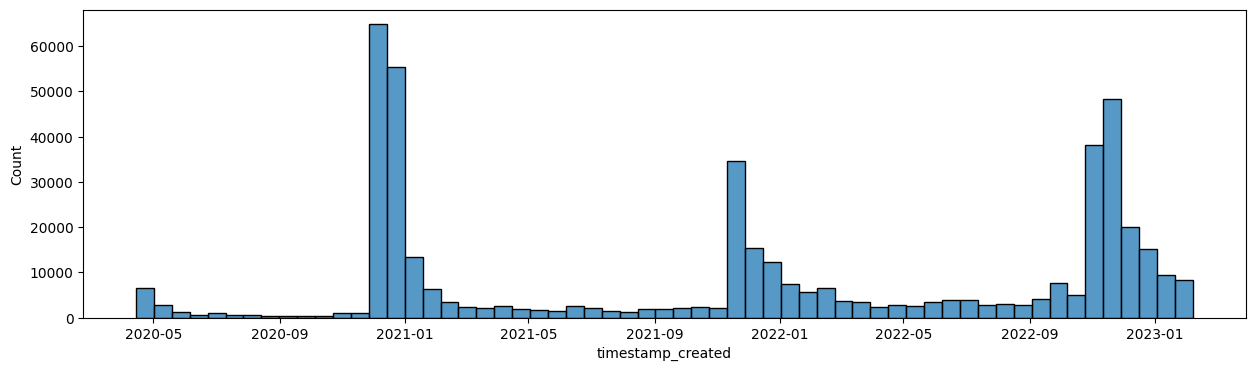

In [7]:
plt.figure(figsize=(15,4))
sns.histplot(x=df.timestamp_created)

In [8]:
# date of 95th quantile reviews
df.timestamp_created.quantile(0.95)

Timestamp('2022-12-28 00:00:00')

In [9]:
%%time
X = df['review']

X_holdout = X[df.timestamp_created >= df.timestamp_created.quantile(0.95)]
X = X[df.timestamp_created < df.timestamp_created.quantile(0.95)]

X

CPU times: total: 0 ns
Wall time: 16 ms


6282           great game might update gpu make work better
6283      theyve fixed game pretty well couple bug encou...
6284                           cuz really wanna stay housee
6285                               finally game story great
6286                                               bee knee
                                ...                        
462573      game wajib untuk budak ea sungkem yang mulia ea
462574    lot change fifa afterall finally good feeling ...
462575    first time played ultimate team got honest tot...
462576    loved game much waiting fifa 22 since august w...
462577                                fifa nothing else say
Name: review, Length: 439032, dtype: object

In [10]:
y = df['voted_up'][df.timestamp_created < df.timestamp_created.quantile(0.95)]
y_holdout = df['voted_up'][df.timestamp_created >= df.timestamp_created.quantile(0.95)]

In [11]:
X.shape, y.shape, X_holdout.shape, y_holdout.shape

((439032,), (439032,), (23546,), (23546,))

### Bag of words

In [12]:
def bow_vectorizer(X_train, X_test, n_features):
    vectorizer = CountVectorizer(max_features = n_features, dtype = np.uint8)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
    return X_train, X_test

### TF IDF

In [13]:
def tfidf_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

### TF IDF with bigram

In [14]:
def tfidf2g_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

## 3. Baseline models

### Function for metrics

In [15]:
columns = ['model name', 'data', 'time', 
           'train_down_Pre',
           'train_down_Rec',
           'train_down_F1',
           'train_up_Pre',
           'train_up_Rec',
           'train_up_F1',
           'train_acc',
           'test_down_Pre',
           'test_down_Rec',
           'test_down_F1',
           'test_up_Pre',
           'test_up_Rec',
           'test_up_F1',
           'test_acc']
           
df_metrics = pd.DataFrame(columns = columns)

In [16]:
def reset(df_metrics):
    return pd.DataFrame(columns = columns)

In [17]:
def classifier_performance(model_name, model, X_name, X_train, X_test, y_train, y_test, cf=False):
    print('Training: ', model_name, '/', X_name)
    start = time.time()
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    complete_time = time.time() - start
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)
    
    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, X_name, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    
    if cf:
        print('Train')
        print(classification_report(y_train, y_hat_train))
        print('Test')
        print(classification_report(y_test, y_hat_test))
        
        fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(6,3))
        labels = ['Negative', 'Positive']
        
        sns.heatmap(confusion_matrix(y_train, y_hat_train), annot=True, ax=ax1, 
                    cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
        sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax2, 
                    cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
        ax1.set(ylabel='Actual', xlabel='Predicted') 
        ax2.set(ylabel='Actual', xlabel='Predicted')
        plt.tight_layout()
        plt.show()
    print(f'Finished in {complete_time:.2f}')
    print('='*80)

### Loop models and data

In [18]:
df_metrics = reset(df_metrics)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=14)

NB_classifier = MultinomialNB()
X_train_bow_2000, X_test_bow_2000 = bow_vectorizer(X_train, X_test, 2000)

LG_classifier = LogisticRegression(random_state = 14)
X_train_tfidf2g_1500, X_test_tfidf2g_1500 = tfidf2g_vectorizer(X_train, X_test, 1500)

models = [
    # use NB with bow_vectorizer, 2000 features
    ('NB_classifier', NB_classifier, X_train_bow_2000, X_test_bow_2000),
    # use LG with tfidf2g_vectorizer, 1500 features
    ('LG_classifier', LG_classifier, X_train_tfidf2g_1500, X_test_tfidf2g_1500)
         ]

Training:  NB_classifier / NB_classifier
Train
              precision    recall  f1-score   support

       False       0.78      0.72      0.75    120213
        True       0.86      0.90      0.88    231012

    accuracy                           0.84    351225
   macro avg       0.82      0.81      0.81    351225
weighted avg       0.83      0.84      0.83    351225

Test
              precision    recall  f1-score   support

       False       0.78      0.71      0.75     30053
        True       0.86      0.90      0.88     57754

    accuracy                           0.83     87807
   macro avg       0.82      0.81      0.81     87807
weighted avg       0.83      0.83      0.83     87807



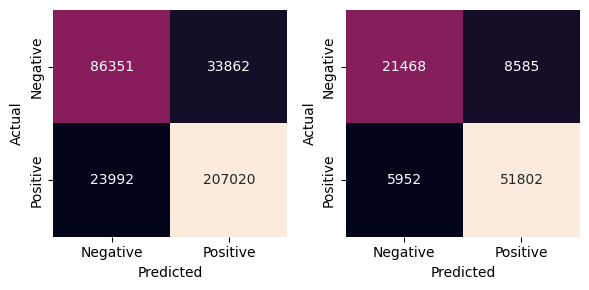

Finished in 14.24
Training:  LG_classifier / LG_classifier
Train
              precision    recall  f1-score   support

       False       0.83      0.74      0.78    120213
        True       0.87      0.92      0.90    231012

    accuracy                           0.86    351225
   macro avg       0.85      0.83      0.84    351225
weighted avg       0.86      0.86      0.86    351225

Test
              precision    recall  f1-score   support

       False       0.83      0.73      0.78     30053
        True       0.87      0.92      0.89     57754

    accuracy                           0.86     87807
   macro avg       0.85      0.83      0.84     87807
weighted avg       0.86      0.86      0.86     87807



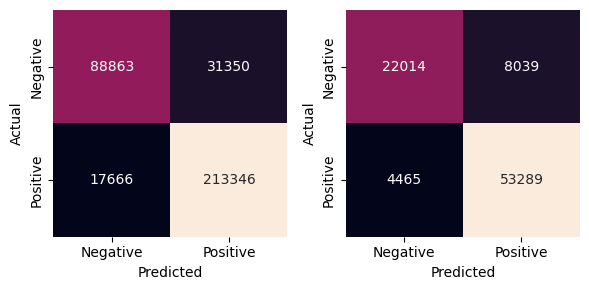

Finished in 34.96


In [20]:
for model_name, model, X_train_data, X_test_data in models:
    classifier_performance(model_name, model, model_name, 
                           X_train_data, X_test_data, y_train, y_test, cf=True)

### AUC

In [21]:
summary = ['model name', 'data', 'time', 'train_acc','test_acc', 'test_up_F1','test_down_F1']
df_metrics[summary]

,model name,data,time,train_acc,test_acc,test_up_F1,test_down_F1
0,NB_classifier,NB_classifier,14.239846,0.835279,0.834444,0.876952,0.747064
1,LG_classifier,LG_classifier,34.956553,0.860443,0.857597,0.894997,0.778816


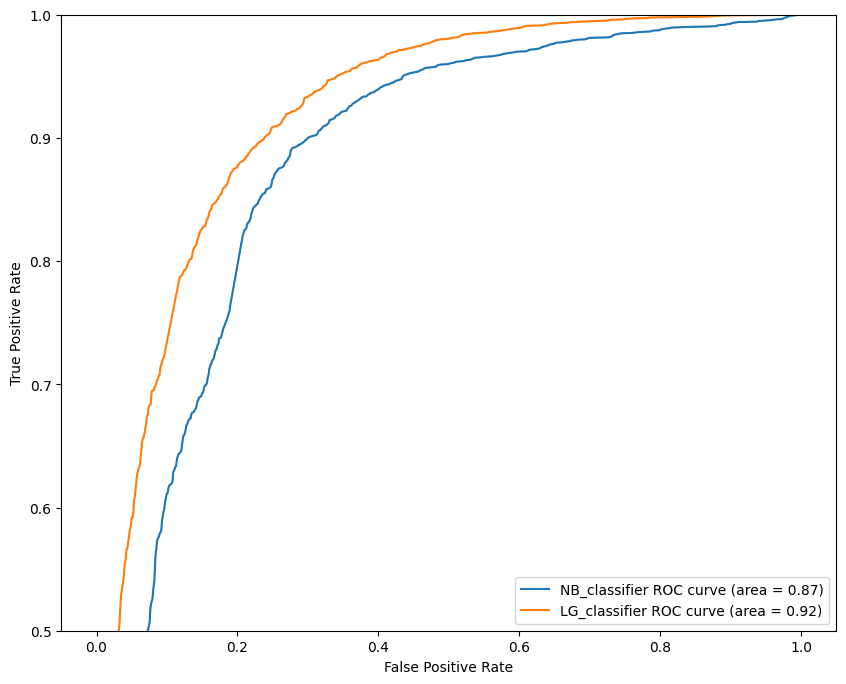

In [22]:

plt.figure(figsize=(10,8))
for model_name, model, X_train_data, X_test_data in models:
    yhat_proba = model.predict_proba(X_test_data[:5000])[:,1]
    fpr, tpr, _ = roc_curve(y_test[:5000],  yhat_proba)
    auc_score = roc_auc_score( y_test[:5000], yhat_proba )
    sns.lineplot(x=fpr,y=tpr, label=model_name + ' ROC curve (area = %0.2f)' % auc_score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.ylim(0.5,1)
plt.show()    

### Adjust logistic regression model threshold

There's a high number of False positive prediction in both models, which led to low recall for False class, which affected F1 score.

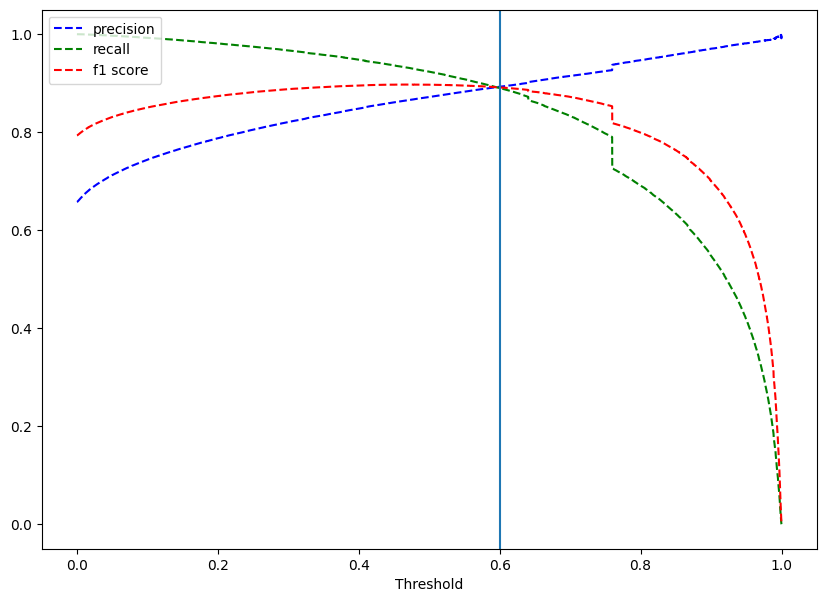

In [23]:
# function to plot precision/recall curve
def pre_rec_curve(model, X_data, threshold=0.5):
    y_proba= model.predict_proba(X_data)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba, pos_label=1)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)

    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    # plt.ylim([0.6,1])
    plt.axvline(threshold)
    plt.show()

pre_rec_curve(LG_classifier, X_train_tfidf2g_1500, threshold=0.6)

**Make prediction with the optimal threshold**

In [25]:
threshold = 0.6
yhat_train = LG_classifier.predict_proba(X_train_tfidf2g_1500)[:,1] > threshold
yhat_test = LG_classifier.predict_proba(X_test_tfidf2g_1500)[:,1] > threshold

Train
              precision    recall  f1-score   support

       False       0.79      0.79      0.79    120213
        True       0.89      0.89      0.89    231012

    accuracy                           0.86    351225
   macro avg       0.84      0.84      0.84    351225
weighted avg       0.86      0.86      0.86    351225

Test
              precision    recall  f1-score   support

       False       0.79      0.79      0.79     30053
        True       0.89      0.89      0.89     57754

    accuracy                           0.86     87807
   macro avg       0.84      0.84      0.84     87807
weighted avg       0.86      0.86      0.86     87807



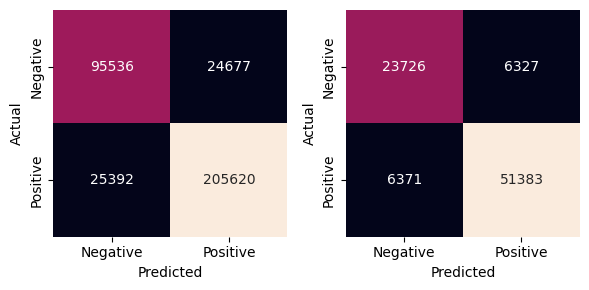

In [26]:
print('Train')
print(classification_report(y_train, yhat_train))
print('Test')
print(classification_report(y_test, yhat_test))

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(6,3))
labels = ['Negative', 'Positive']

sns.heatmap(confusion_matrix(y_train, yhat_train), annot=True, ax=ax1, 
            cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, ax=ax2, 
            cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
ax1.set(ylabel='Actual', xlabel='Predicted') 
ax2.set(ylabel='Actual', xlabel='Predicted')
plt.tight_layout()
plt.show()

## Conclusion

- On the full data, we have achieve a best F1 of 0.79, AUC 0.92 with Logistic regression model. This will be the benchmark for the DL model.